### Projet de Compressed Sensing


# Analyse d'images en astronomie: ondelettes et inpainting

*Léa Bresson, Arnaud Valladier*

### Sommaire

[1. Introduction](#intro)<br>
[2. Préparation des données](#prep)<br>
[3. MCA Inpainting](#inp1)<br>
[4. Nuclear Norm Minimisation](#inp2)<br>
[5. Proximal Gradient Descent](#inp3)<br>
[6. Benchmark des différentes méthodes](#benchmark)<br>
[7. Influence des hyperparamètres](#hyp)<br>
[8. Conclusion](#conclu)<br>


<a id='intro'></a>
## 1. Introduction


Le problème des données manquantes est récurrent dans le domaine de l'astronomie. En effet, les images issues des microscopes souffrent souvent de "zones d'ombres" (mauvaise qualité de l'image, mauvaise calibration, etc.). Les techniques d'*inpainting* consistent à "remplir" ces zones masquées.


**Formalisation du problème:**

Soient X l'image complète (non observée), Y l'image observée souffrant de zone "masquées", et L un masque binaire. On a $Y=LX$. L'objectif est alors de retrouver X sachant que l'on connait Y et L. Pour résoudre ce problème, nous comparons deux techniques: 

- la première méthode se place dans une base d'ondelettes et effectue une approximation par seuillage itératif (méthode de J.L Starck et J. Bobin dans leur article "*Astronomical Data Analysis and Sparsity: from Wavelets to Compressed Sensing*"). L'approche mathématique d'un tel algorithme est développée dans notre rapport.

- la seconde technique repose sur les techniques de complétion de matrices (ici matrices de pixels) par minimisation de la norme nucléaire étudiées en cours (http://lecueguillaume.github.io/assets/10_matrice_completion.pdf). Plus précisément, on comparera  la formulation SDP du problème de minimisation de la norme nucléaire et la descente de gradient proximale.


L'objet de ce notebook est donc de vérifier si l'algorithme basé sur les ondelettes est, comme le suggérerait la théorie, plus efficace pour estimer des images présentant des structures fractales.



**Implémentation:**

Nous allons implémenter la technique de l'inpainting à une photo prise par le télescope Herschel (https://www.herschel.caltech.edu/images). Pour ce faire, nous appliquons un masque binaire à l'image considérée.


Nous nous sommes inspirés des codes de Jerome Bobin pour la première méthode (le code du fichier pyPW2 a été crée par J.Bobin - http://jbobin.cosmostat.org/master-2-mva).

<a id='prep'></a>
## 2. Préparation des données

In [1]:
import numpy as np
import pandas as pd
import astropy.io.fits as pyf # nécessite "pip install astropy"
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import scipy.ndimage as sim
from cvxpy import *
print(installed_solvers())

# L'implémention de l'algorithme à trous et de la déconvolution sont présents dans le fichier pyPW2.py
# import pyPW2_modif as pw2
import pyPW2_modif as pw2

#ONLY IF YOU USE DUNOVANK NOTEBOOK THEME:

# from jupyterthemes import jtplot
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='oceans16', grid=False)

['SCS', 'GLPK_MI', 'ECOS_BB', 'LS', 'ECOS', 'GLPK', 'CVXOPT']


Prenons par l'exemple l'image `'black_hole_wind_new'` dans le jeu de données proposée. Pour ne pas avoir des calculs trop long, nous en prendrons seulement une partie.

Text(0.5,1,'Input image')

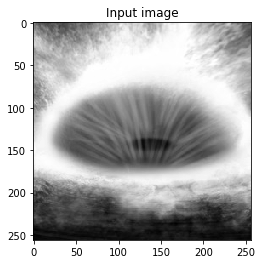

In [2]:
# Conversion de l'image en image numérique/tableau de pixels
cmap = 'gray' # or coolwarm or Greys or gray
f = plt.imread('Data/black_hole_wind_new.jpg').astype('double') #(longueur, largeur, couleur chanel)
f = f[120:(120 + 256), 200:(200 + 256):]
x = np.sum(f,axis=2) #(longueur, largeur)
plt.imshow(x, cmap=cmap)
plt.title('Input image')

Création d'un masque binaire, la proportion de pixels non-masqués est fixée par défaut à $0.4$.

In [3]:
def mask_generator(u, v, proportion = 0.4, random_state=42):
    """
    Generate a mask given the shape of the matrix (u, v) and the proportion of known entries of the matrix
    Random state is fixed by default. random_state='None' randomize it.
    """
    if random_state is None:
        mat_mask = np.random.binomial(1, proportion, size =  (u, v))
    else: 
        rng = np.random.RandomState(random_state)
        mat_mask = rng.binomial(1, proportion, size =  (u, v))
    print("We observe %.2f" % (100 * mat_mask.mean()) + " per cent of the entries of a {}*{} matrix".format(u, v))
    return mat_mask

Prenons un exemple en gardant $60\%$ des données:

We observe 39.99 per cent of the entries of a 256*256 matrix


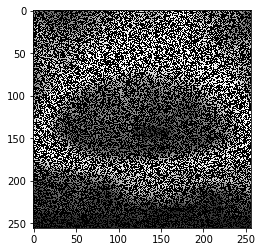

In [4]:
plt.imshow(x * mask_generator(x.shape[0], x.shape[1], 0.4), cmap=cmap)

Création d'une fonction plot qui sera utilisée pour illustrer nos algorithmes:

In [5]:
def plot_inpainting(input_image, inpainted, masked, mask, error=None):
    """
    Plot the input image, the inpainted image, the masked image, the mask and the residuals
    """
    plt.figure(figsize=(25.0, 12.0))
    #If the error is not given, we compute it
    if error is None:
        error = np.linalg.norm(inpainted - input_image, 2) / np.linalg.norm(input_image, 2)
    plt.suptitle('Inpainting: erreur relative = %.2e' % error, fontsize=20.0)
    plt.subplot(2, 3, 1)
    plt.imshow(input_image,cmap=cmap)
    plt.title('Input image')
    plt.subplot(2, 3, 2)
    plt.imshow(inpainted, cmap=cmap)
    plt.title('Inpainted image')
    plt.subplot(2, 3, 3)
    plt.imshow(masked,cmap=cmap)
    plt.title('Masked')
    plt.subplot(2, 3, 4)
    plt.imshow(mask,cmap=cmap)
    plt.title('Mask')
    plt.subplot(2, 3, 5)
    plt.imshow(input_image - inpainted, cmap=cmap)
    plt.title('Residuals')
    plt.show()

<a id='inp1'></a>
## 3. MCA Inpainting


Nous utilisons l'algorithme 'MCA inpainting' décrit par l'article au sein d'une fonction destinée à apprécier ses performances:

In [6]:
def inpainting_astro(input_image, nmax=500, J=3, k_mad=3, tol=1e-4, mask=None, proportion=0.4, random_state=42, error=True, timer=True, plot=True):
    """
    Inpainting using Isotropic Undecimated Wavelet Transform (IUWT)
    Input : input_image - N x M array 
            nmax - scalar - maximum number of iterations
            J - scalar - number of starlet scales
            k_mad - scalar - value of the k-mad threshold
            tol - scalar - stoppin criterion 
            mask - N x M array (binary mask) - if 'None', a binomial mask is calculated
            proportion - if mask=None, represented the proportion of unmodified pixel of the masked image.
                         If 'mask' is not 'None', 'proportion' is ignored.
            error - True => the relative error in 2-norm is returned
            timer - True => print the time consummed by the algorithm
            plot - True => plot several image: the input, the inpainted, the masked, the mask and the residuals
    Output : inpainted - N x M array
             err - scalar - relative error in 2-norm (if error=True)
    """
    #Timer initialization
    start = time()
    #Create a mask if corresponding argument is 'None'
    if mask is None:
        n, p = input_image.shape
        mask = mask_generator(n, p, proportion, random_state=42)
    #Creation of the masked image
    masked = np.multiply(mask, input_image)
    #Run of the procedure
    start_inpainting = time()
    inpainted = pw2.Prox_Inp(masked, mask, nmax, J, k_mad, tol)
    #Print timer
    if timer:
        print("Inpainting time: %.2f" % (time() - start_inpainting) + "s")
    #Plot the input image, the masked image, the inpainted image on the first line
    #Plot the mask and the residuals on the second line
    if plot:       
        plot_inpainting(input_image, inpainted, masked, mask)
    #Return total timer
    if timer:
        print("Total time of the procedure: %.2f" % (time() - start) + "s") 
    #Return the inpainted matrix (and the error)       
    if error:
        err = np.linalg.norm(inpainted - input_image, 2) / np.linalg.norm(input_image, 2)
        print("Erreur relative: %.4f" % err)
        return inpainted, err
    else:
        return inpainted

La ligne ```python inpainted = pw2.Prox_Inp(masked, mat_mask , nmax, J, k_mad, tol)```  implémente un algorithme forward backward qui minimise le problème suivant:
$$ min_x \text{  } \lambda ||x \phi ^T ||_{\ell_1} + \frac{1}{2}||b-M \otimes x ||_2^2 $$ 

Avec $b$ l'image observée, $\phi^T$ la transformée en ondelettes isotropes (appelée aussi *"Starlet transform"*) , $M$ le masque binaire et $x$ l'image que l'on souhaite retrouver.

*NOTE*: il n'est pas nécessaire de run la prochaine cellule pour la suite du code.

We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 115.51s


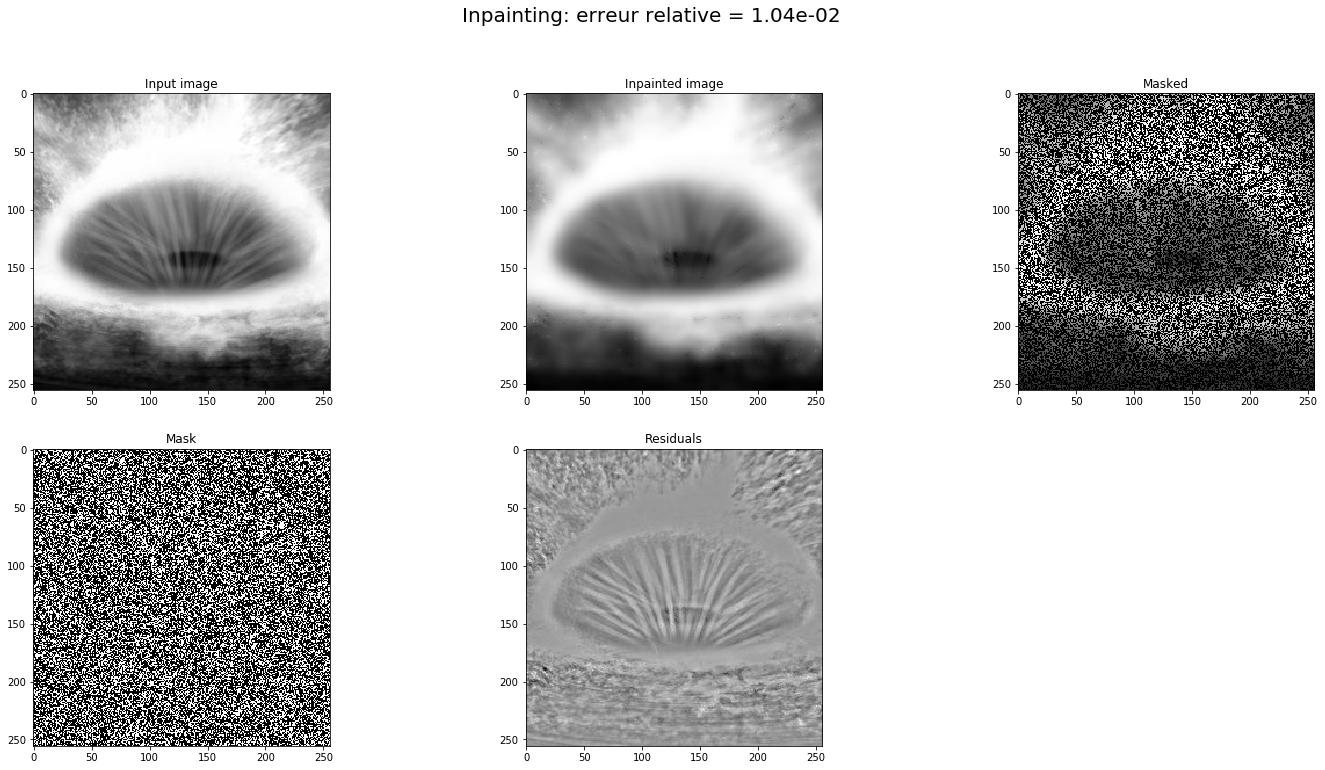

Total time of the procedure: 117.70s
Erreur relative: 0.0104


In [8]:
x_inpainted_astro, error_astro = inpainting_astro(x)

Compte tenu du fort pourcentage de pixels manquant, ici $60\%$, la reconsitution est surprenament bonne. Toutefois, on constate que les détails de l'image n'ont pas été reconstruit et sont visiblement présents dans les résidus.

<a id='inp2'></a>
## 4. Nuclear Norm Minimization

Nous souhaitons comparer l'algorithme précédant avec les techniques vues en cours. En supposant que l'image recherchée est sparse, à l'aide de $m$ mesures de l'image, on cherche à reconstruire celle-ci. On cherche donc à minimiser le problème suivant:
\begin{align*}
\left\{ \begin{array}{l}
\arg\min_{A \in \mathbb{R}^{u\times v}} rg(A)\\
\langle A, X_i \rangle = y_i, \forall i \in \{1 \ldots m\}
\end{array}\right.
\end{align*}

La relaxation convexe du problème sur $\mathcal{B}_{S_\infty}$ est le suivant:
\begin{align*}
\left\{ \begin{array}{l}
\arg\min_{A \in \mathbb{R}^{u\times v}} \Vert A\Vert_{S_1}\\
\langle A, X_i \rangle = y_i, \forall i \in \{1 \ldots m\}
\end{array}\right.
\end{align*}

Le solveur de `cvxpy` peut donc être utilisé:

In [9]:
def nuclear_norm_mini(mat_mask, image):
    """
    Solver of Nuclear Norm Minimization using cvxpy
    """
    #Problem setting
    u, v = image.shape
    A = Variable(u, v)
    obj = Minimize(norm(A, 'nuc'))
    constraints = [mul_elemwise(mat_mask, A) == mul_elemwise(mat_mask, np.array(image))]
    prob = Problem(obj, constraints)
    #Process
    prob.solve(solver=SCS)
    if prob.status != 'optimal':
        print('CVXPY failed to reach optimal value')
    return A.value

In [10]:
def inpainting_NNM(input_image, mask=None, proportion=0.4, random_state=42, error=True, timer=True, plot=True):
    """
    Inpainting using Nuclear Norm Minimization (NNM)
    Input : input_image - N x M array 
            mask - N x M array (binary mask) - if 'None', a binomial mask is calculated
            proportion - if mask=None, represented the proportion of unmodified pixel of the masked image
                         If 'mask' is not 'None', 'proportion' is ignored.
            error - True => the relative error in 2-norm is returned
            timer - True => print the time consummed by the algorithm
            plot - True => plot several image: the input, the inpainted, the masked, the mask and the residuals
    Output : inpainted - N x M array
             err - scalar - relative error in 2-norm (if error=True)
    """
    start = time()
    #Create a mask if corresponding argument is 'None'
    if mask is None:
        n, p = input_image.shape
        mask = mask_generator(n, p, proportion, random_state=42)
    #Creation of the masked image
    masked = np.multiply(mask, input_image)
    #Run of the procedure
    start_inpainting = time()
    inpainted = nuclear_norm_mini(mask, input_image)
    #Print timer
    if timer:
        print("Inpainting time: %.2f" % (time() - start_inpainting) + "s")
    #Plot the input image, the masked image, the inpainted image on the first line
    #Plot the mask and the residuals on the second line
    if plot:
        plot_inpainting(input_image, inpainted, masked, mask)
    #Return total timer
    if timer:
        print("Total time of the procedure: %.2f" % (time() - start) + "s") 
    #Return the inpainted matrix (and the error)       
    if error:
        err = np.linalg.norm(inpainted - input_image, 2) / np.linalg.norm(input_image, 2)
        print("Erreur relative: %.4f" % err)
        return inpainted, err
    else:
        return inpainted

We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 134.26s


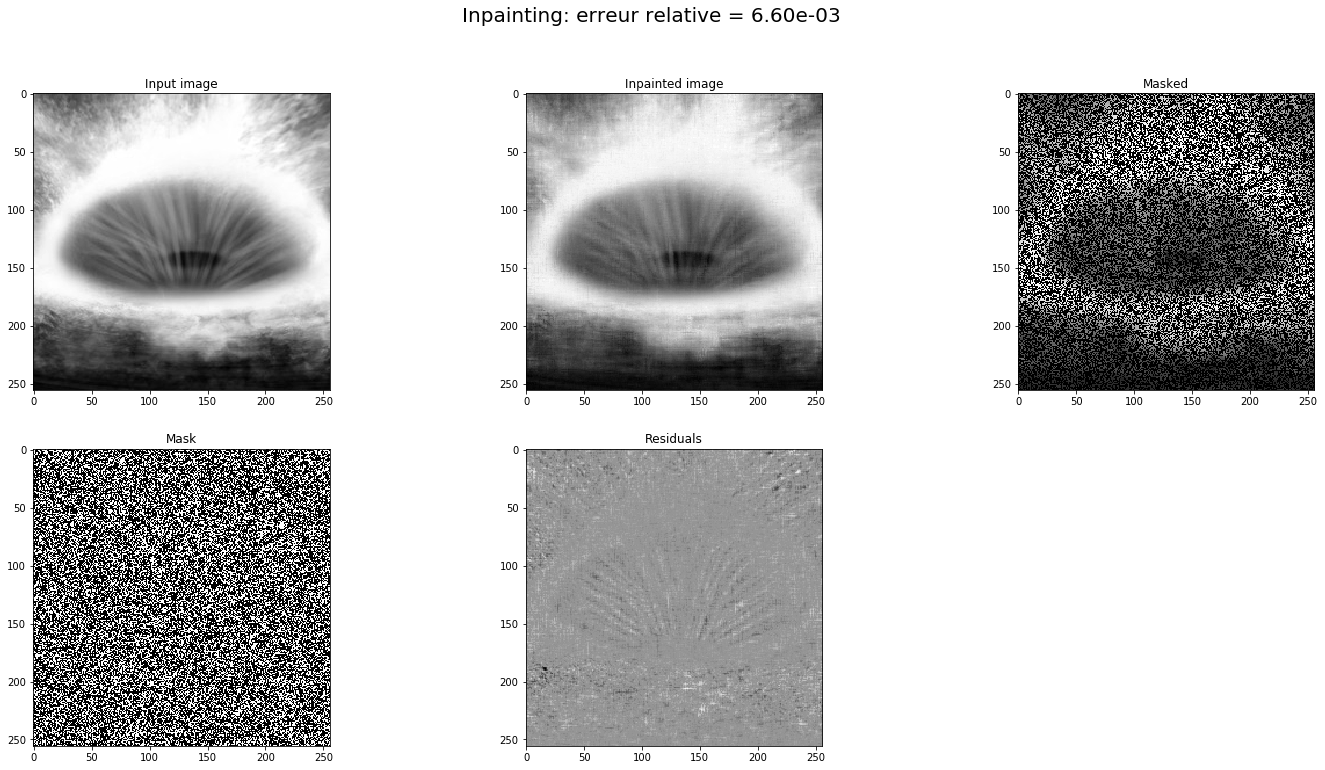

Total time of the procedure: 135.77s
Erreur relative: 0.0066


In [11]:
x_inpainted_NNM, error_NNM = inpainting_NNM(x)

L'erreur relative de cette méthode est très proche de celle de la méthode précédente. La reconstruction semble plus hachée que dans les résultats précédents, cependant ont observe ici que les résidus sont nettement plus vagues que précédemment. Les détails semblent avoir été mieux capturés, au dépent d'une certaine "smoothness" de l'image reconstruite. 

<a id='inp3'></a>
## 5. Proximal Gradient Descent

Nous souhaitons maintenant comparer les deux méthodes précédentes avec les méthodes de gradient proximal. Celles-ci consiste à résoudre:

\begin{align}
\arg\min_{A\in \mathbb{R}^{u\times v}} \frac{1}{2}\Vert P_\Omega(A) - P_\Omega(A^*)\Vert_{S_2}^2 + \lambda \Vert A \Vert_{S_1}
\end{align}
Cela se résout par descente de gradient proximale où l'opérateur proximal du premier problème correspond à un opérateur de seuillage doux.

In [12]:
from numpy.linalg import svd

In [13]:
def spectral_soft_thresh(A, mu):
    """Compute the spectral soft thresholding"""
    U, s, V = svd(A)
    s_mu = np.multiply((s - mu), (s > mu))
    return np.dot(U, np.dot(np.diag(s_mu), V))

In [14]:
def prox_grad_descent(image, image_masked, mat_mask, mu, step_size=1, n_iter=400, tol=1e-4,  verbose = False):
    """
    Compute the proximal gradient descent using spectral soft thresholding
    """
    list_errors = []
    A = np.zeros(image_masked.shape)
    for i in range(n_iter + 1):
        A = spectral_soft_thresh(np.multiply(A, (1 - step_size * mat_mask)) + step_size * image_masked, mu)
        err = np.linalg.norm(A - image, 2) / np.linalg.norm(image, 2)
        list_errors.append(err)
        #If verbose
        if i % 20 == 0 and verbose == True:
            print("iteration = {}; error = {}".format(i, err))
            plt.figure
            plt.imshow(A, cmap = plt.cm.gray)
            plt.show()
        #Stoppin criterium
        if err < tol: break
    return A, list_errors

In [15]:
def inpainting_PGD(input_image, mu=200, step_size=1, n_iter=400, tol=1e-4, mask=None, proportion=0.4, random_state=42, timer=True, plot=True):
    """
    Inpainting using Proximal Gradient Descent
    Input : input_image - N x M array 
            mu - scalar - soft thresholding
            step_size - scalar or str - must be strictly positive
            n_iter - integer - number of iterations in proximal gradient descent
            tol - scalar - stoppin criterium on the relative error
            mask - N x M array (binary mask) - if 'None', a binomial mask is calculated
            proportion - if mask=None, represented the proportion of unmodified pixel of the masked image
                         If 'mask' is not 'None', 'proportion' is ignored
            timer - True => print the time consummed by the algorithm
            plot - True => plot several image: the input, the inpainted, the masked, the mask and the residuals
    Output : inpainted - N x M array
             err - scalar - relative error in 2-norm
    """
    start = time()
    #Create a mask if corresponding argument is 'None'
    if mask is None:
        n, p = input_image.shape
        mask = mask_generator(n, p, proportion, random_state=42)
    #Creation of the masked image
    masked = np.multiply(mask, input_image)
    #Run of the procedure
    start_inpainting = time()
    inpainted, err = prox_grad_descent(input_image, masked, mask, mu, step_size, n_iter, tol=tol, verbose = False)
    #Print timer
    if timer:
        print("Inpainting time: %.2f" % (time() - start_inpainting) + "s")
    #Plot the input image, the masked image, the inpainted image on the first line
    #Plot the mask and the residuals on the second line
    if plot:
        plot_inpainting(input_image, inpainted, masked, mask)
    #Return total timer
    if timer:
        print("Total time of the procedure: %.2f" % (time() - start) + "s") 
    #Return the inpainted matrix (and the error)  
    print("Erreur relative: %.4f" % err[-1])
    return inpainted, err[-1]

We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 19.70s


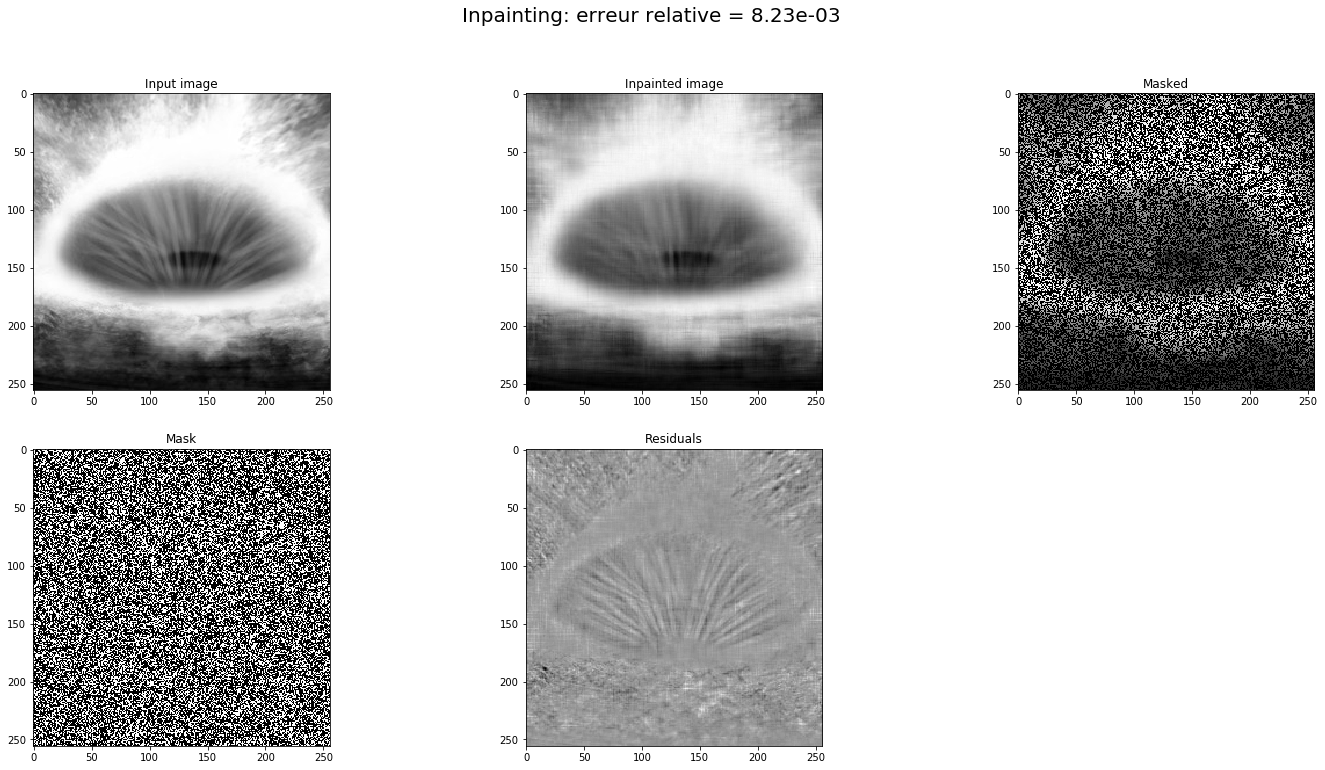

Total time of the procedure: 21.17s
Erreur relative: 0.0082


In [16]:
x_soft_PGD, error_soft_PGD = inpainting_PGD(x)

Nous constatons que les performances des trois algorithmes présentés sont similaires en termes de taux d'erreur. Les vitesses de calcul sont, quant à elles, très hétérogènes (118 secondes pour le MCA contre 21 secondes pour le proximal GD). 

Les performances des algorithmes sont très dépendantes de la proportion de pixel masqués (fixée à 60% ci-dessus). L'objet de la prochaine section est de comparer les algorithmes lorsque cette proportion varie.

<a id='benchmark'></a>
## 6. Benchmark des différentes méthodes

Nous calculons l'erreur commise et le temps nécessaire aux calculs pour chaque méthode dans le but de comparer leurs performances.

In [17]:
proportion = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def benchmark(method, input_image, proportion=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """
    Compute the relative error the inpainted image given a method and a set of proportion of known entries of the input image
    Benchmark++ : compute each error several time and take the average => better benchmark but time consuming!!! =(
    """
    errors = []
    timer = []
    for prop in proportion:
        start = time()
        _, err = method(input_image, plot=False, proportion=prop)
        timer.append(time() - start)
        errors.append(err)
    return np.array(errors), np.array(timer)

#### ATTENTION: les calculs sont assez longs.
#### Il n'est pas nécéssaire de run les 3 prochaines cellules:
Les résultats ont été enregistrés dans des fichiers pour ne pas avoir à refaire les calculs. 

In [18]:
benchmark_astro, timer_astro = benchmark(inpainting_astro, x)
save_astro = pd.DataFrame([benchmark_astro, timer_astro, proportion]).T
save_astro.to_csv('benchmark_astro.csv')

We observe 9.93 per cent of the entries of a 256*256 matrix
Inpainting time: 672.28s
Total time of the procedure: 672.28s
Erreur relative: 0.0486
We observe 19.92 per cent of the entries of a 256*256 matrix
Inpainting time: 262.69s
Total time of the procedure: 262.69s
Erreur relative: 0.0153
We observe 29.84 per cent of the entries of a 256*256 matrix
Inpainting time: 152.49s
Total time of the procedure: 152.49s
Erreur relative: 0.0122
We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 59.54s
Total time of the procedure: 59.54s
Erreur relative: 0.0104
We observe 49.99 per cent of the entries of a 256*256 matrix
Inpainting time: 48.28s
Total time of the procedure: 48.28s
Erreur relative: 0.0092
We observe 60.01 per cent of the entries of a 256*256 matrix
Inpainting time: 34.47s
Total time of the procedure: 34.47s
Erreur relative: 0.0082
We observe 70.16 per cent of the entries of a 256*256 matrix
Inpainting time: 31.89s
Total time of the procedure: 31.89s
Erre

In [19]:
benchmark_NNM, timer_NNM = benchmark(inpainting_NNM, x)
save_NNM = pd.DataFrame([benchmark_NNM, timer_NNM, proportion]).T
save_NNM.to_csv('benchmark_NNM.csv')

We observe 9.93 per cent of the entries of a 256*256 matrix
Inpainting time: 50.51s
Total time of the procedure: 50.52s
Erreur relative: 0.0397
We observe 19.92 per cent of the entries of a 256*256 matrix
Inpainting time: 66.68s
Total time of the procedure: 66.69s
Erreur relative: 0.0199
We observe 29.84 per cent of the entries of a 256*256 matrix
Inpainting time: 74.42s
Total time of the procedure: 74.42s
Erreur relative: 0.0106
We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 82.78s
Total time of the procedure: 82.78s
Erreur relative: 0.0066
We observe 49.99 per cent of the entries of a 256*256 matrix
Inpainting time: 98.80s
Total time of the procedure: 98.80s
Erreur relative: 0.0046
We observe 60.01 per cent of the entries of a 256*256 matrix
Inpainting time: 105.49s
Total time of the procedure: 105.49s
Erreur relative: 0.0031
We observe 70.16 per cent of the entries of a 256*256 matrix
Inpainting time: 115.35s
Total time of the procedure: 115.35s
Erreur

In [20]:
benchmark_PGD, timer_PGD = benchmark(inpainting_PGD, x)
save_PGD = pd.DataFrame([benchmark_PGD, timer_PGD, proportion]).T
save_PGD.to_csv('benchmark_PGD.csv')

We observe 9.93 per cent of the entries of a 256*256 matrix
Inpainting time: 11.39s
Total time of the procedure: 11.40s
Erreur relative: 0.0940
We observe 19.92 per cent of the entries of a 256*256 matrix
Inpainting time: 11.20s
Total time of the procedure: 11.20s
Erreur relative: 0.0214
We observe 29.84 per cent of the entries of a 256*256 matrix
Inpainting time: 11.42s
Total time of the procedure: 11.43s
Erreur relative: 0.0125
We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 11.30s
Total time of the procedure: 11.30s
Erreur relative: 0.0082
We observe 49.99 per cent of the entries of a 256*256 matrix
Inpainting time: 11.58s
Total time of the procedure: 11.59s
Erreur relative: 0.0061
We observe 60.01 per cent of the entries of a 256*256 matrix
Inpainting time: 11.18s
Total time of the procedure: 11.18s
Erreur relative: 0.0044
We observe 70.16 per cent of the entries of a 256*256 matrix
Inpainting time: 11.05s
Total time of the procedure: 11.05s
Erreur rel

In [21]:
benchmark_astro = pd.read_csv('benchmark_astro.csv', index_col=0, names=['Erreur', 'Timer', 'Proportion'], header=0)
benchmark_NNM = pd.read_csv('benchmark_NNM.csv', index_col=0, names=['Erreur', 'Timer', 'Proportion'], header=0)
benchmark_PGD = pd.read_csv('benchmark_PGD.csv', index_col=0, names=['Erreur', 'Timer', 'Proportion'], header=0)

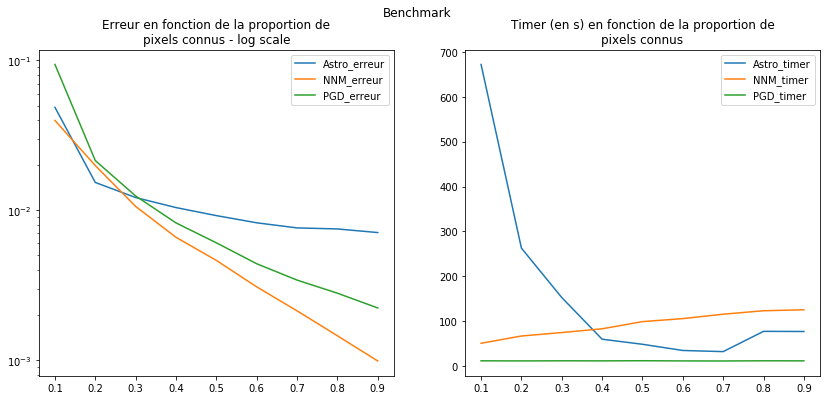

In [22]:
plt.figure(figsize=(14.0, 6.0))
plt.suptitle('Benchmark')
plt.subplot(1,2,1)
plt.title('Erreur en fonction de la proportion de\npixels connus - log scale')
plt.semilogy(benchmark_astro.Proportion, benchmark_astro.Erreur, label='Astro_erreur')
plt.semilogy(benchmark_astro.Proportion, benchmark_NNM.Erreur, label='NNM_erreur')
plt.semilogy(benchmark_astro.Proportion, benchmark_PGD.Erreur, label='PGD_erreur')
plt.legend()
plt.subplot(1,2,2)
plt.title('Timer (en s) en fonction de la proportion de\npixels connus')
plt.plot(benchmark_astro.Proportion, benchmark_astro.Timer, label='Astro_timer')
plt.plot(benchmark_astro.Proportion, benchmark_NNM.Timer, label='NNM_timer')
plt.plot(benchmark_astro.Proportion, benchmark_PGD.Timer, label='PGD_timer')
plt.legend()

Les performances de la méthode NNM sont meilleures que celle du MCA (astro_erreur) concernant l'erreur de reconstruction (sauf lorsque p=0.2). Cependant, le MCA est nettement plus rapide dès que la proportion de pixels connue est supérieure ou égale à $0.3$. La méthode PGD montre des résultats similaires à la NNM et se révèle être beaucoup plus rapide que les deux autres. PGD ne dépasse pas les 20 secondes, cet algorithme est donc entre 2 à 10 fois plus rapide que les deux autres méthodes.

On remarque un cap entre les proportions $0.1$ et $0.2$. En effet, entre ces deux valeurs, la précision des deux méthodes chute drastiquement. De plus, de manière assez contre-intuitive, la vitesse de convergence de la méthode NNM croit lorsque la proportion de pixels connus augmente.

De la même façon, concernant l'algorithme MCA, on constate que les timers pour des proportions de $0.8$ et $0.9$ sont plus élevés que le timer correspondant à la proportion $0.7$.

Ces observations sont-elles liées à une mauvaise calibration de l'algorithme MCA ? Est-il possible d'améliorer la performance de l'algorithme PGD ? L'objet de la prochaine section est d'optimiser les algorithmes présentés ci-dessus grâce à un choix pertinent de la valeur de leurs hyper-paramètres.


<a id='hyp'></a>
# 7. Influence des hyper-paramètres

Fixons une proportion de pixels connues à $0.4$. Déterminons les meilleurs paramètres possible pour chaque algorithme.

## 7.1 Proximal Gradient Descent: influence du seuil $\mu$

In [31]:
import pylab as pl
from IPython import display
from time import sleep

On fixe un masque et une proportion de pixel connues pour l'image étudiée. Nous allons calculer l'erreur relative en norme deux concernant la qualité de la reconstruction pour chaque valeur de $\mu$ choisie. Nous commençons par tester des valeurs de $\mu$ entre $50$ et $1000$ par pas de $50$.
#### Attention! Les calculs prennent entre 5 et 10 minutes
Mais il y a une animation après! Ça vaut le coup de les lancer =)

In [24]:
error = []
inpainted_list = []

mask = mask_generator(x.shape[0], x.shape[1], proportion=0.4)
masked = np.multiply(x, mask)

mu_list = np.arange(0, 1000, 50) + 50

for mu in mu_list:
    inpainted, err = inpainting_PGD(x, mu=mu, mask=mask, proportion=0.4, plot=False)
    error.append(err)
    inpainted_list.append(inpainted)

We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 11.14s
Total time of the procedure: 11.14s
Erreur relative: 0.0272
Inpainting time: 11.74s
Total time of the procedure: 11.74s
Erreur relative: 0.0073
Inpainting time: 11.12s
Total time of the procedure: 11.12s
Erreur relative: 0.0077
Inpainting time: 10.73s
Total time of the procedure: 10.73s
Erreur relative: 0.0082
Inpainting time: 10.90s
Total time of the procedure: 10.90s
Erreur relative: 0.0089
Inpainting time: 11.19s
Total time of the procedure: 11.19s
Erreur relative: 0.0096
Inpainting time: 10.92s
Total time of the procedure: 10.92s
Erreur relative: 0.0105
Inpainting time: 11.05s
Total time of the procedure: 11.05s
Erreur relative: 0.0114
Inpainting time: 11.48s
Total time of the procedure: 11.48s
Erreur relative: 0.0123
Inpainting time: 11.44s
Total time of the procedure: 11.44s
Erreur relative: 0.0132
Inpainting time: 11.10s
Total time of the procedure: 11.10s
Erreur relative: 0.0141
Inpainting time

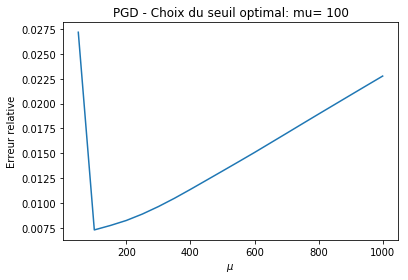

In [25]:
plt.plot(mu_list, error)
plt.title("PGD - Choix du seuil optimal: mu= %d" % mu_list[np.argmin(error)])
plt.xlabel('$\mu$')
plt.ylabel('Erreur relative')
plt.show()

On constate que le minimum trouvé est assez grossier. Pour l'approcher plus finement, considéront des valeurs régulières de $\mu$ entre $50$ et $100$:

In [26]:
error_bis = []
inpainted_list_bis = []

mask = mask_generator(x.shape[0], x.shape[1], proportion=0.4)
masked = np.multiply(x, mask)

mu_list_bis = np.arange(50, 110, 10)

for mu in mu_list_bis:
    inpainted, err = inpainting_PGD(x, mu=mu, mask=mask, proportion=0.4, plot=False)
    error_bis.append(err)
    inpainted_list_bis.append(inpainted)

We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 12.82s
Total time of the procedure: 12.82s
Erreur relative: 0.0272
Inpainting time: 11.91s
Total time of the procedure: 11.91s
Erreur relative: 0.0086
Inpainting time: 11.26s
Total time of the procedure: 11.26s
Erreur relative: 0.0073
Inpainting time: 10.79s
Total time of the procedure: 10.79s
Erreur relative: 0.0071
Inpainting time: 10.85s
Total time of the procedure: 10.85s
Erreur relative: 0.0072
Inpainting time: 11.29s
Total time of the procedure: 11.29s
Erreur relative: 0.0073


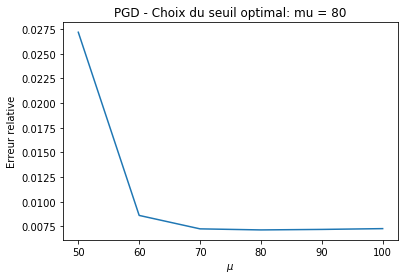

In [27]:
plt.plot(mu_list_bis, error_bis)
plt.title("PGD - Choix du seuil optimal: mu = %d" % mu_list_bis[np.argmin(error_bis)])
plt.xlabel('$\mu$')
plt.ylabel('Erreur relative')
plt.show()

La plus faible erreur relative est obtenue pour $\mu = 80$. La courbe est assez plate entre $70$ et $90$ pour se sentir satisfait de ce minimiseur.

Voyons l'évolution de la reconstitution en faisant varier $\mu$ de $1000$ jusqu'à $80$.

*EDIT*: Nous sommes assez fier de notre petite animation! Si vous voulez bien vous donnez la peine de run les deux cellules suivantes =)

In [28]:
mu_list = np.arange(0,1000,50) + 50

error_reverse = error[::-1]
mu_list_reverse = mu_list[::-1]
inpainted_list_reverse = inpainted_list[::-1]

error_reverse = error_reverse[0:22:2]
mu_list_reverse = mu_list_reverse[0:22:2]
inpainted_list_reverse = inpainted_list_reverse[0:22:2]

mu_list_reverse = np.append(mu_list_reverse, mu_list_bis[np.argmin(error_bis)])
error_reverse.append(np.min(error_bis))
inpainted_list_reverse.append(inpainted_list_bis[np.argmin(error_bis)])


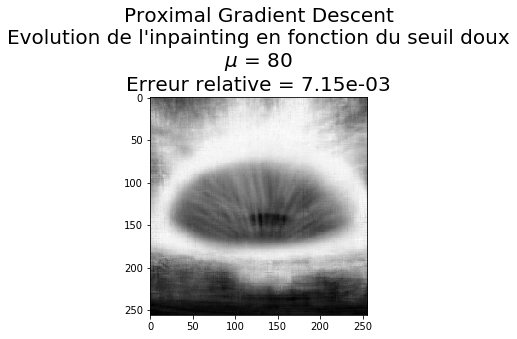

In [29]:
# Animation 

for i in range(len(inpainted_list_reverse)):
    plt.title("Proximal Gradient Descent\nEvolution de l'inpainting en fonction du seuil doux\n$\mu$ = %d" % mu_list_reverse[i] + 
                 "\nErreur relative = %.2e" % error_reverse[i], fontsize=20.0)
    plt.imshow(inpainted_list_reverse[i], cmap=cmap)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(1)

L'amélioration de la reconstruction est visible!

De la même façon, regardons l'influence de $\mu$ sur les résidus:

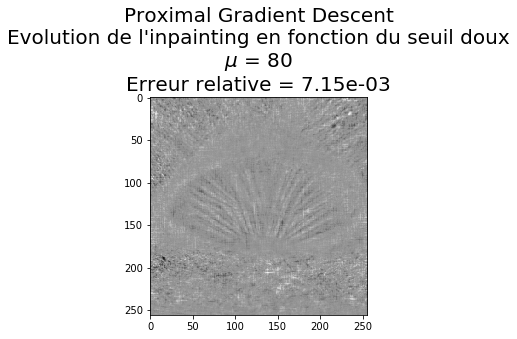

In [30]:
# Animation

for i in range(len(error_reverse)):
    plt.title("Proximal Gradient Descent\nEvolution de l'inpainting en fonction du seuil doux\n$\mu$ = %d" % mu_list_reverse[i] + 
                 "\nErreur relative = %.2e" % error_reverse[i], fontsize=20.0)
    plt.imshow(x - inpainted_list_reverse[i], cmap=cmap)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(1)

On constate une différence visible de la reconstitution en fonction de l'hyper-paramètre.

## 7.2 Proximal Gradient Descent: influence du step size

In [33]:
error = []
inpainted_list = []

mask = mask_generator(x.shape[0], x.shape[1], proportion=0.4)
masked = np.multiply(x, mask)

step_size_list = [0.5, 1, 1.3, 1.5, 1.7, 1.9, 2.0]

for step_size in step_size_list:
    inpainted, err = inpainting_PGD(x, step_size=step_size, mu=80, mask=mask, proportion=0.4, plot=False)
    error.append(err)
    inpainted_list.append(inpainted)

We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 10.58s
Total time of the procedure: 10.58s
Erreur relative: 0.0078
Inpainting time: 10.02s
Total time of the procedure: 10.02s
Erreur relative: 0.0071
Inpainting time: 10.08s
Total time of the procedure: 10.08s
Erreur relative: 0.0070
Inpainting time: 11.10s
Total time of the procedure: 11.10s
Erreur relative: 0.0070
Inpainting time: 10.91s
Total time of the procedure: 10.91s
Erreur relative: 0.0069
Inpainting time: 10.61s
Total time of the procedure: 10.61s
Erreur relative: 0.0069
Inpainting time: 10.91s
Total time of the procedure: 10.91s
Erreur relative: 0.0074


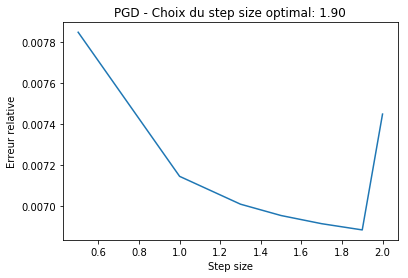

In [34]:
plt.plot(step_size_list, error)
plt.title("PGD - Choix du step size optimal: %.2f" % step_size_list[np.argmin(error)])
plt.xlabel('Step size')
plt.ylabel('Erreur relative')
plt.show()

On remarque que pour une valeur de $\mu=80$, le step size optimal trouvé est $1.9$. Nous pourrions affiner localement autour de $1.9$ la recherche d'un meilleurs stepsize. On peut constater que ce paramètre est source d'instabilité. Par exemple, si l'on choisi un step size à $2.1$, l'erreur explose:

Inpainting time: 10.96s


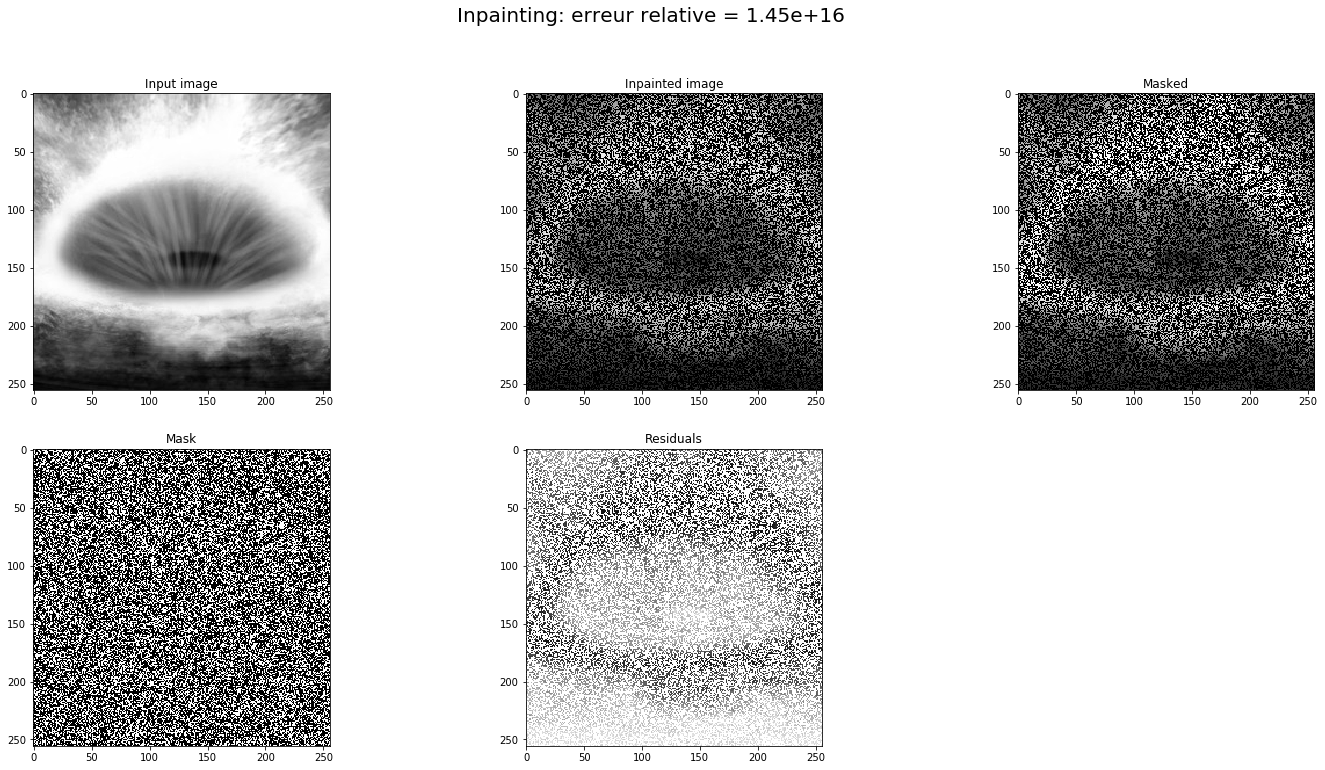

Total time of the procedure: 11.69s
Erreur relative: 14458208286919732.0000


In [35]:
_, _ = inpainting_PGD(x, step_size=2.1, mu=80, mask=mask, proportion=0.4, plot=True)

Ce paramètre doit donc être choisi avec soin.

Inpainting time: 10.15s


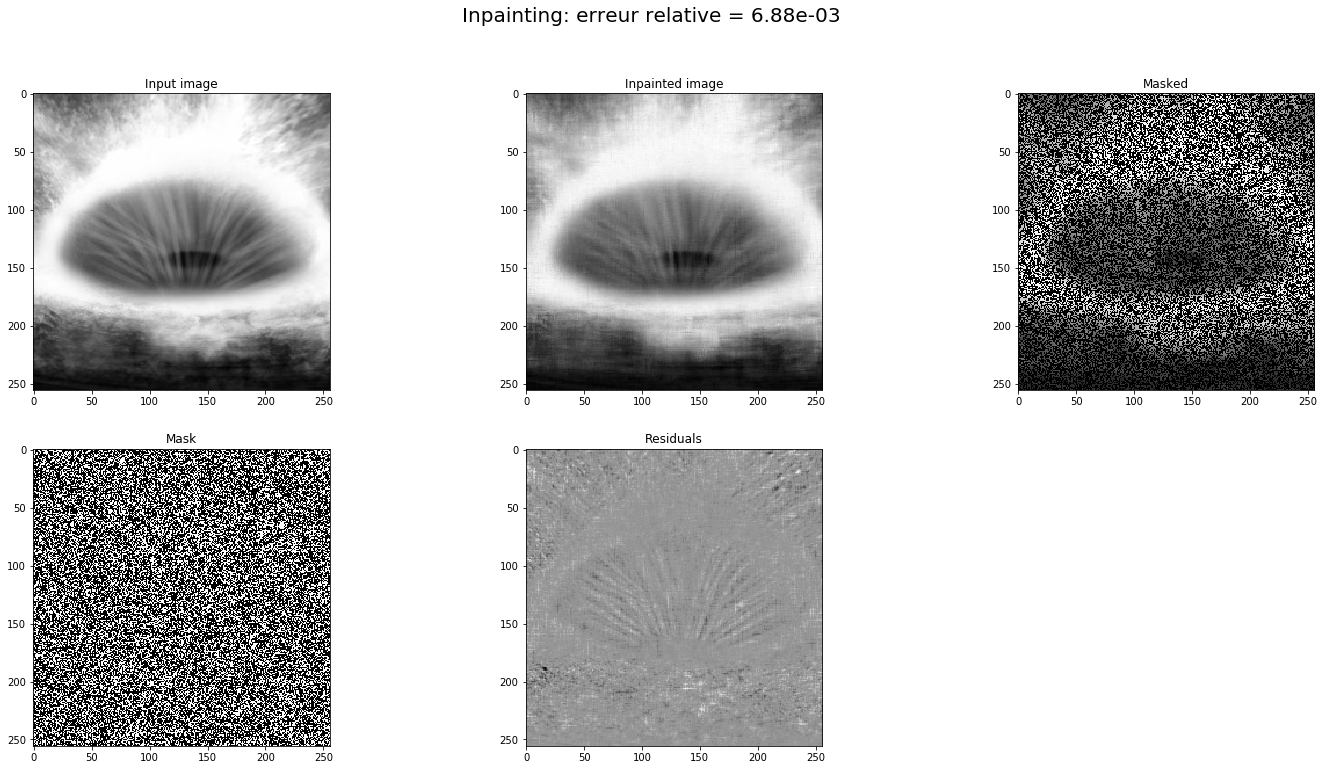

Total time of the procedure: 10.90s
Erreur relative: 0.0069


In [36]:
_, _ = inpainting_PGD(x, step_size=1.9, mu=80, mask=mask, proportion=0.4, plot=True)

## 7.3 UIWT: choix du seuil k_mad

In [37]:
k_mad_list = [1, 2, 3, 4, 5]

inpainted_iuwt = []
error_iuwt = []

for k_mad in k_mad_list:
    inpainted, err = inpainting_astro(x, k_mad=k_mad, mask=mask, proportion=0.4, plot=False)
    error_iuwt.append(err)
    inpainted_iuwt.append(inpainted)

Inpainting time: 108.70s
Total time of the procedure: 108.70s
Erreur relative: 0.0072
Inpainting time: 60.92s
Total time of the procedure: 60.92s
Erreur relative: 0.0095
Inpainting time: 64.81s
Total time of the procedure: 64.81s
Erreur relative: 0.0104
Inpainting time: 65.09s
Total time of the procedure: 65.09s
Erreur relative: 0.0108
Inpainting time: 68.09s
Total time of the procedure: 68.09s
Erreur relative: 0.0110


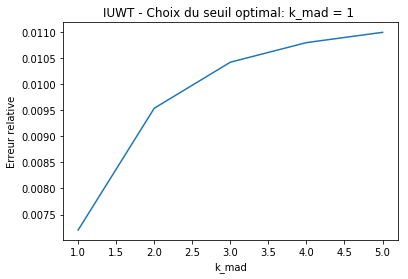

In [38]:
plt.plot(k_mad_list, error_iuwt)
plt.title("IUWT - Choix du seuil optimal: k_mad = %d " % k_mad_list[np.argmin(error_iuwt)])
plt.xlabel('k_mad')
plt.ylabel('Erreur relative')
plt.show()

Nous rejouons l'algorithme IUWT en utilisant la valeur optimale k_mad=1.

In [39]:
_,_ = inpainting_astro(x, k_mad=1, mask=mask, proportion=0.4, plot=False)

Inpainting time: 109.33s
Total time of the procedure: 109.33s
Erreur relative: 0.0072



<a id='conclu'></a>
# 8. Conclusion

Les méthodes d'inpainting permettent de reconstruire une image malgrès une très forte proportion de pixels manquants.

L'avantage des ondelettes ne ressort pas clairement de cette analyse: lorsque 60% des pixels d'une photo sont masqués, la méthode MCA est certes légérement plus précise que la méthode PGD mais l'algorithme est très lent. 

**Comparaison des algorithmes à leurs meilleurs temps(pour p=0.4): **

| Algorithme           | Errreur       | Running time |
| ---------------------|:-------------:| ------------:|
| MCA (k_mad = 1)      | 0.0069        |   109.33     |
| NNM                  | 0.0066        |   135.77     |
| PGD (step=1.9, mu=80)| 0.0082        |   21.17      |



Lorsque la proportion des pixels non masqués augmente la méthode MCA devient la moins précise. Au vu de ces résultats, la méthode de descente de gradient proximale semble très intéressante et présente le meilleur compromis précision/temps d'éxecution. De plus, sa facilité d'implémentation en font une bonne méthode *"base line"* pour la complétion d'image. Cependant, cet algorithme est sensible quant au choix des hyperparamètre. En particulier, le pas dans la descente de gradient doit être choisi avec soin.
